In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.model_selection import train_test_split

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('normal_pneumonia_train.npy', 'rb') as f:
    x_ray_features = np.load(f)
    x_ray_labels = np.load(f)

    
X_train, X_test, y_train, y_test = train_test_split(x_ray_features, x_ray_labels, 
                                                    test_size=2000, random_state=242)

classes = ['Normal', 'Pneumonia']

X_all = np.concatenate((X_train,X_test))

n = X_train.shape[0]


print(x_ray_features.shape)
print(X_train.shape, y_train.shape, X_train.dtype, np.sum(y_train==0), np.sum(y_train==1))
print(X_test.shape, y_test.shape, X_test.dtype, np.sum(y_test==0), np.sum(y_test==1))
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(13389, 1024)
(11389, 1024) (11389,) float32 6775 4614
(2000, 1024) (2000,) float32 1191 809
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull

legend_elements = [Line2D([0], [0], marker='.', lw=0, color='c', label='Normal'),
                   Line2D([0], [0], marker='.', lw=0, color='g', label='Pneumonia'),
                   #Line2D([0], [0], marker='.', lw=0, color='b', label='COVID-19'),
                   Line2D([0], [0], marker='*', lw=0, color='r', label='Normal (Test)'),
                   Line2D([0], [0], marker='*', lw=0, color='m', label='Pneumonia (Test)'),
                   #Line2D([0], [0], marker='*', lw=0, color='k', label='COVID-19 (Test)'),
                  ]


def plot_umap(y_umap, y_train, umap_test=None, y_test=None,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename=None, if_legend=False, loc='upper right'):
    
    colors = ['c', 'g', 'b', 'k']
    #markers = ['.', '+', '*', 'o']
    markers = ['.', '.', '.']
    markers_2 = ['.', '.', '.']
    colors_2 = ['r', 'm', 'k']

    #rot_angle = -55#np.pi - np.arctan(m2) #-60 for saved model, -50 for seed 100
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    mn = np.mean(y_umap, axis=0)

    Y = y_umap - mn
    Y = rot_mat.dot(Y.T).T

    hull = ConvexHull(Y)

    markersize = 5
    
    verts = hull.vertices
    verts = np.append( verts, hull.vertices[0] ) 

    plt.figure()
    #plt.title('UMAP - Non Parametric')

    for i in range(y_umap.shape[0]):
        plt.plot(x_neg*Y[i,0], y_neg*Y[i,1], 
                 color = colors[y_train[i]], 
                 marker = markers[y_train[i]],
                 markersize=markersize,alpha=0.1)
        
    plt.plot(x_neg*Y[verts,0], y_neg*Y[verts,1], 'k--', lw=2, alpha=0.5)

    if umap_test is not None:
        test_points = umap_test - mn
        test_points = rot_mat.dot(test_points.T).T
        
        for i in range(test_points.shape[0]):
            plt.plot(x_neg*test_points[i,0], y_neg*test_points[i,1], 
                    color = colors_2[y_test[i]], 
                    marker = markers_2[y_test[i]],#) #,
                    markersize=markersize)
    plt.xticks([],[])
    plt.yticks([],[])
    
    if if_legend:
        plt.legend(handles=legend_elements, loc=loc)
    
    plt.savefig('Pneumonia_FIGURES_30_Jan_2023/'+filename, bbox_inches='tight', dpi=400)
    return



In [50]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val



In [51]:
sort_idx,_ = get_first_order_graph(X_all,n_neighbors=X_all.shape[0]-1)

Completed  10000  of  13389


In [52]:
sort_idx_tr,_ = get_first_order_graph(X_train,n_neighbors=X_train.shape[0]-1)

Completed  10000  of  11389


<h1>UMAP</h1>

In [54]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

None


<IPython.core.display.Javascript object>

In [55]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap.png', if_legend=True, loc='upper left')

<IPython.core.display.Javascript object>

In [56]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=2, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>

In [57]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (TRAIN->TEST)
1-NN error:  0.23850000000000005
5-NN error:  0.1905


In [58]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


Trustworthiness: UMAP (TRAIN->TEST)
5:  0.8334546255706319
30:  0.8326186261316175
100:  0.831433437566457
Trustworthiness: UMAP (TRAIN)
5:  0.8345030920771325
30:  0.8332185928633391
100:  0.8314659424170234


<h1>Neg Sampling: 3</h1>

In [59]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        #n_epochs = 4000,
        metric= 'euclidean')

print(ump.n_epochs)


y_umap = ump.fit_transform(X_train)
ump.negative_sample_rate = 3
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

None


<IPython.core.display.Javascript object>

In [60]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap_neg_3.png', if_legend=False)

<IPython.core.display.Javascript object>

In [61]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (n_s=3) (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (n_s=3) (TRAIN->TEST)
1-NN error:  0.25049999999999994
5-NN error:  0.1785


In [62]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (n_s=3) (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


Trustworthiness: UMAP (n_s=3) (TRAIN->TEST)
5:  0.8339692031638919
30:  0.832967936487229
100:  0.8315166074226124
Trustworthiness: UMAP (TRAIN)
5:  0.8345030920771325
30:  0.8332185928633391
100:  0.8314659424170234


<h1>Neg Sampling=1</h1>

In [63]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

#ump.negative_sample_rate = 0

y_umap = ump.fit_transform(X_train)

ump.negative_sample_rate = 1

y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

None


<IPython.core.display.Javascript object>

In [64]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap_neg_1.png', if_legend=False)

<IPython.core.display.Javascript object>

In [65]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (TRAIN->TEST)
1-NN error:  0.22750000000000004
5-NN error:  0.1725


In [66]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)


print('Trustworthiness: UMAP (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)


Trustworthiness: UMAP (TRAIN->TEST)
5:  0.8329431893349637
30:  0.8315300299781033
100:  0.8304070466146776
Trustworthiness: UMAP (TRAIN)
5:  0.8345030920771325
30:  0.8332185928633391
100:  0.8314659424170234


<h1>Combined Train and Test Data<h1>

<IPython.core.display.Javascript object>


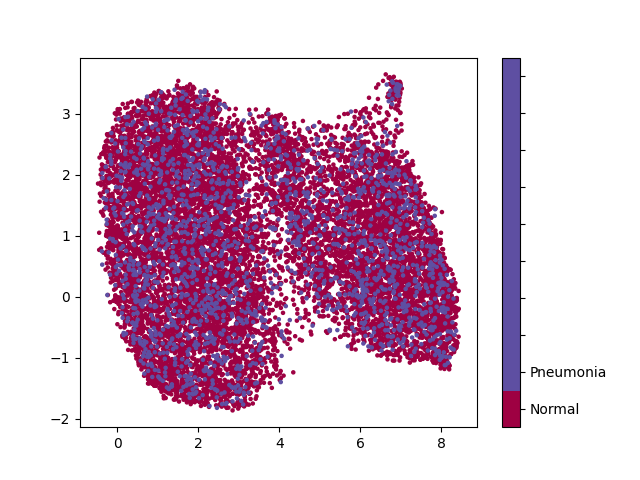

In [96]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

y_umap = t_umap_all[:X_train.shape[0]]
y_umap_test = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=5, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>


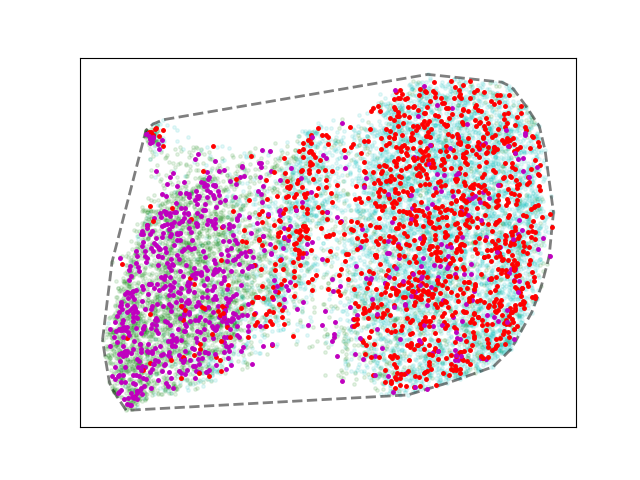

In [97]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = -10, x_neg = -1, y_neg = 1,
              filename='pneu_umap_no_comb.png', if_legend=False)

In [69]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP (TRAIN+TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(y_umap, y_train)

y_nene_out = neigh.predict(y_umap_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)

Nearest Neighbor: UMAP (TRAIN+TEST)
1-NN error:  0.239
5-NN error:  0.1785


In [70]:
t_umap_tr_te = np.concatenate((y_umap,y_umap_test))

tt_tr_te_5 = my_trustworthiness(t_umap_tr_te, sort_idx, K=5)
tt_tr_te_30 = my_trustworthiness(t_umap_tr_te, sort_idx, K=30)
tt_tr_te_100 = my_trustworthiness(t_umap_tr_te, sort_idx, K=100)

print('Trustworthiness: UMAP (TRAIN->TEST)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

tt_tr_te_5 = my_trustworthiness(y_umap, sort_idx_tr, K=5)
tt_tr_te_30 = my_trustworthiness(y_umap, sort_idx_tr, K=30)
tt_tr_te_100 = my_trustworthiness(y_umap, sort_idx_tr, K=100)

print('Trustworthiness: UMAP (TRAIN)')
print('5: ', tt_tr_te_5)
print('30: ', tt_tr_te_30)
print('100: ', tt_tr_te_100)

Trustworthiness: UMAP (TRAIN->TEST)
5:  0.8340151960326864
30:  0.8329649475048447
100:  0.831535716955567
Trustworthiness: UMAP (TRAIN)
5:  0.8328494463304921
30:  0.8323614168279616
100:  0.8308417790714332


<h1>UMAP CE</h1>

In [71]:
from scipy.io import loadmat

d = loadmat('nets_pneumonia_UMAP_CE/test_data39.mat')
t_ce = d['Y'].copy()
t_ce_test = d['Y_test'].copy()
t_ce_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


In [72]:
plt.figure()
plt.scatter(t_ce_tr_te[:,0], t_ce_tr_te[:,1], c=y_all, s=1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>

In [73]:
plot_umap(t_ce, y_train, t_ce_test, y_test,
              rot_angle = 75, x_neg = 1, y_neg = -1,
              filename='pneu_pumap_ce.png', if_legend=False)

<IPython.core.display.Javascript object>

In [74]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP CE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_ce, y_train)

y_nene_out = neigh.predict(t_ce_test)

err_tsne = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_tsne)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_ce, y_train)

y_nene_out = neigh.predict(t_ce_test)

err_tsne_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_tsne_5)


Nearest Neighbor: UMAP CE (TRAIN->TEST)
1-NN error:  0.22299999999999998
5-NN error:  0.16149999999999998


In [75]:
tt_ce_5 = my_trustworthiness(t_ce_tr_te, sort_idx, K=5)
tt_ce_30 = my_trustworthiness(t_ce_tr_te, sort_idx, K=30)
tt_ce_100 = my_trustworthiness(t_ce_tr_te, sort_idx, K=100)

print('UMAP CE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_ce_5)
print('30: ', tt_ce_30)
print('100: ', tt_ce_100)

tt_ce_5 = my_trustworthiness(t_ce, sort_idx_tr, K=5)
tt_ce_30 = my_trustworthiness(t_ce, sort_idx_tr, K=30)
tt_ce_100 = my_trustworthiness(t_ce, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_ce_5)
print('30: ', tt_ce_30)
print('100: ', tt_ce_100)


UMAP CE
Trustworthiness: (Train->Test) 
5:  0.8400650678529612
30:  0.8402738494092593
100:  0.8409095120932012
Trustworthiness: (Train) 
5:  0.843001945814573
30:  0.8430290709515462
100:  0.8429838815184715


<h1>UMAP MSE</h1>

In [76]:
from scipy.io import loadmat

d = loadmat('nets_MSE_UMAP_pneumonia/test_data19.mat')
t_mse = d['Y'].copy()
t_mse_test = d['Y_test'].copy()
t_mse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


In [77]:
plt.figure()
plt.scatter(t_mse_tr_te[:,0], t_mse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>

In [78]:
plot_umap(t_mse, y_train, t_mse_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_pumap_mse.png', if_legend=False)

<IPython.core.display.Javascript object>

In [79]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP MSE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_mse, y_train)

y_nene_out = neigh.predict(t_mse_test)

err_mse = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_mse)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_mse, y_train)

y_nene_out = neigh.predict(t_mse_test)

err_mse_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_mse_5)


Nearest Neighbor: UMAP MSE (TRAIN->TEST)
1-NN error:  0.23299999999999998
5-NN error:  0.17900000000000005


In [80]:
tt_mse_5 = my_trustworthiness(t_mse_tr_te, sort_idx, K=5)
tt_mse_30 = my_trustworthiness(t_mse_tr_te, sort_idx, K=30)
tt_mse_100 = my_trustworthiness(t_mse_tr_te, sort_idx, K=100)

print('UMAP MSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_mse_5)
print('30: ', tt_mse_30)
print('100: ', tt_mse_100)

tt_mse_5 = my_trustworthiness(t_mse, sort_idx_tr, K=5)
tt_mse_30 = my_trustworthiness(t_mse, sort_idx_tr, K=30)
tt_mse_100 = my_trustworthiness(t_mse, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_mse_5)
print('30: ', tt_mse_30)
print('100: ', tt_mse_100)


UMAP MSE
Trustworthiness: (Train->Test) 
5:  0.8324902767921731
30:  0.8322565299467409
100:  0.8304765372820166
Trustworthiness: (Train) 
5:  0.8344989275387997
30:  0.8338196478411508
100:  0.831503873894909


<h1>UMAP CEMSE</h1>

In [81]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP_peumonia/test_data19.mat')
t_cemse = d['Y'].copy()
t_cemse_test = d['Y_test'].copy()
t_cemse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


In [82]:
plt.figure()
plt.scatter(t_cemse_tr_te[:,0], t_cemse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<IPython.core.display.Javascript object>

In [83]:
plot_umap(t_cemse, y_train, t_cemse_test, y_test,
              rot_angle = 5, x_neg = 1, y_neg = 1,
              filename='pneu_pumap_cemse.png', if_legend=False)

<IPython.core.display.Javascript object>

In [84]:
from sklearn.neighbors import KNeighborsClassifier

print('Nearest Neighbor: UMAP CEMSE (TRAIN->TEST)')

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(t_cemse, y_train)

y_nene_out = neigh.predict(t_cemse_test)

err_cemse = 1-np.mean(y_nene_out==y_test)

print('1-NN error: ', err_cemse)

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(t_cemse, y_train)

y_nene_out = neigh.predict(t_cemse_test)

err_cemse_5 = 1-np.mean(y_nene_out==y_test)
print('5-NN error: ', err_cemse_5)


Nearest Neighbor: UMAP CEMSE (TRAIN->TEST)
1-NN error:  0.23150000000000004
5-NN error:  0.17000000000000004


In [85]:
tt_cemse_5 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=5)
tt_cemse_30 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=30)
tt_cemse_100 = my_trustworthiness(t_cemse_tr_te, sort_idx, K=100)

print('UMAP CEMSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

tt_cemse_5 = my_trustworthiness(t_cemse, sort_idx_tr, K=5)
tt_cemse_30 = my_trustworthiness(t_cemse, sort_idx_tr, K=30)
tt_cemse_100 = my_trustworthiness(t_cemse, sort_idx_tr, K=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

UMAP CEMSE
Trustworthiness: (Train->Test) 
5:  0.8379218280754303
30:  0.8393239075214112
100:  0.8397835529469541
Trustworthiness: (Train) 
5:  0.8396775440709877
30:  0.8410134538541025
100:  0.8411369310960471


In [86]:
from sklearn.manifold import trustworthiness

tt_cemse_5 = trustworthiness(X_all, t_cemse_tr_te, n_neighbors=5)
tt_cemse_30 = trustworthiness(X_all, t_cemse_tr_te, n_neighbors=30)
tt_cemse_100 = trustworthiness(X_all, t_cemse_tr_te, n_neighbors=100)

print('UMAP CEMSE')
print('Trustworthiness: (Train->Test) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

tt_cemse_5 = trustworthiness(X_train, t_cemse, n_neighbors=5)
tt_cemse_30 = trustworthiness(X_train, t_cemse, n_neighbors=30)
tt_cemse_100 = trustworthiness(X_train, t_cemse, n_neighbors=100)

print('Trustworthiness: (Train) ')
print('5: ', tt_cemse_5)
print('30: ', tt_cemse_30)
print('100: ', tt_cemse_100)

UMAP CEMSE
Trustworthiness: (Train->Test) 
5:  0.8379218504020656
30:  0.8393239116261311
100:  0.8397835513672669
Trustworthiness: (Train) 
5:  0.8396775841888079
30:  0.8410134582403688
100:  0.8411369336742672
